In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.chdir("..")

In [2]:
import re
import ast
import json
import numpy as np
import pandas as pd
import yaml
import time
import glob

import matplotlib.pyplot as plt

from collections import Counter
from src.utils.math_equivalence import is_math_equiv, extract_boxed_answer
from src.utils.pass_k_utils import estimate_pass_at_k
from math_verify import parse, verify
from tqdm import tqdm
from pathlib import Path
from src import common

In [6]:
import shutil
import re
from dotenv import load_dotenv
from src.sampler.gemini_sampler import GeminiSampler
from src.sampler.claude_sampler import ClaudeCompletionSampler
import json

load_dotenv()

False

In [9]:
from transformers import AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [29]:
template = """You are given a mathematical question along with its partial solution. Your task is to identify and label one primary mathematical skill used in the solution.

Guidelines for skill label:
	- The skill label must be suitable for use as a Python dictionary key.
	- Use lowercase letters only.
	- The skill name should be descriptive.
	- If the skill name contains multiple words, join them using underscores.
	- If the provided solution is nonsense, irrelevant, or does not demonstrate any meaningful mathematical reasoning, output exactly: no_skill


Input:
	- Question: <math question>
	- Solution: <worked solution or explanation>

(Strict) Output format:
<skill_name>, reason: <brief explanation of why this skill applies>

Question:
<question>

Solution:
<solution>
"""

question_holder = "<question>"
solution_holder = "<solution>"

In [11]:
import ast

In [16]:
class Args:
    dataset_name = "aime24"
    # dataset_name = "gsm8k"
    # split = "answerbench_subset"
    # split = "imo-bench-combinatorics-005"
    split="test"
    subset_num = None
    step_by_step_prompt = True
    n_threads = 1
args = Args()

job_dir = f"runs/aime24.qwen2.5-0.5b"
sampler_config_dir = f'{job_dir}/sft_ep1.prefix'

# sampler_config_dir = f'{job_dir}/qwen2.5-math-7b/base.direct/sample_1'
# job_dir = f"runs/v1/{args.dataset_name}.qwen2.5-math-7b"
# sampler_config_dir = f'{job_dir}/base.direct/sample_1'
# sampler_config_dir = f'{job_dir}/rlzero.direct/sample_1'
# sampler_config_dir = f'{job_dir}/rlzero.divpath/sample_1'
print(sampler_config_dir)
prompt_csv_path = f'{job_dir}/{args.split}.prompts.csv'

all_generation_csv = glob.glob(f"{sampler_config_dir}/*/{args.split}.generations*.csv")
# all_generation_csv = glob.glob(f"{sampler_config_dir}/generations*.csv")
all_generation_df = [pd.read_csv(p) for p in all_generation_csv]
# Concatenate all dataframes in all_generation_df into a single dataframe
generation_df = pd.concat(all_generation_df, ignore_index=True)
generation_df['pred_answer'] = generation_df.response.apply(extract_boxed_answer)
generation_df['is_valid'] = generation_df.pred_answer.apply(lambda x: len(x) > 0)
generation_df['is_correct'] = generation_df.apply(lambda row: is_math_equiv(str(row['gt_answer']), str(row['pred_answer'])), axis=1)

def extract_prefix(row):
    # response = row['response']
    # first_token = tokenizer.tokenize(response[:50])[0]

    first_token = ast.literal_eval(row['sampler_config'].strip())['sampler'].get('thinking_prefix', "default")
    # print(eval(row['sampler_config'].strip()).get('thinking_prefix', "default"))
    return first_token

generation_df['prefix'] = generation_df.apply(extract_prefix, axis=1)

runs/aime24.qwen2.5-0.5b/sft_ep1.prefix


In [17]:
generation_df

,question_id,prompt_id,response,pred_answer,gt_answer,sampler_config,is_valid,is_correct,prefix
0,0,0,to use the concept of average speed.\nSince A...,,204,"{'sampler': {'class': 'VLLMSampler', 'model_na...",False,False,The approach to solve this problem is
1,0,0,to use the formula for the time taken to walk...,,204,"{'sampler': {'class': 'VLLMSampler', 'model_na...",False,False,The approach to solve this problem is
2,0,0,to set up an equation and solve for the varia...,4,204,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,The approach to solve this problem is
3,0,0,to set up a system of equations based on the ...,180,204,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,The approach to solve this problem is
4,0,0,to use the concept of work and distance. Let'...,,204,"{'sampler': {'class': 'VLLMSampler', 'model_na...",False,False,The approach to solve this problem is
...,...,...,...,...,...,...,...,...,...
30715,29,29,to consider the constraints of the problem.\n...,3093,902,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,The approach to solve this problem is
30716,29,29,to consider the problem as placing the chips ...,120,902,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,The approach to solve this problem is
30717,29,29,to use the principle of inclusion-exclusion.\...,2025,902,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,The approach to solve this problem is
30718,29,29,to count the number of ways to arrange the ch...,24,902,"{'sampler': {'class': 'VLLMSampler', 'model_na...",True,False,The approach to solve this problem is


In [25]:
prompts_df = pd.read_csv(prompt_csv_path)
prompts = {}
for _, row in prompts_df.iterrows():
    prompts[row['prompt_id']] = row['question']

dataset = []
for row_id, row in generation_df.iterrows():
    if row['question_id'] == 22 and row['is_valid']:
        pred_answer = parse(row['pred_answer'])
        if len(pred_answer) > 0:
            dataset.append({
                "id": row_id,
                "question_id": row['question_id'],
                "prompt": prompts[row['prompt_id']],
                "prefix": row['prefix'],
                "completion": row['prefix'] + row['response'].split("\n")[0],
                "is_valid": row['is_valid'],
                "is_correct": row['is_correct'],
                # "pred_answer": pred_answer,
            })

In [26]:
len(dataset)

722

In [27]:
dataset[-1]

{'id': 29823,
 'question_id': 22,
 'prompt': 'A list of positive integers has the following properties:\n$\\bullet$ The sum of the items in the list is $30$.\n$\\bullet$ The unique mode of the list is $9$.\n$\\bullet$ The median of the list is a positive integer that does not appear in the list itself.\nFind the sum of the squares of all the items in the list.',
 'prefix': 'The approach to solve this problem is',
 'completion': 'The approach to solve this problem is to first find the mode of the list and then find the median.',
 'is_valid': True,
 'is_correct': False}

In [33]:
# sampler = ClaudeCompletionSampler(
#     # model="gemini-2.0-flash",
#     # model="gemini-2.5-pro",
#     model="gemini-2.5-flash",
#     system_message=None,
#     max_tokens=256
# )

sampler = ClaudeCompletionSampler(
    # model="claude-sonnet-4-5-20250929",
    model="claude-haiku-4-5-20251001",
    max_tokens=20,
)

In [34]:
save_interval = 100
save_directory = sampler_config_dir
global_start_idx = 0

def fn(sample):
    prompt = template.replace(question_holder, sample['prompt']).replace(solution_holder, sample['completion'])
    message_list = [
        {"role": "user", "content": prompt},
    ]
    response = sampler(message_list)
    sample['claude_label'] = response.choices[0].response_text
    return sample

samples = dataset
all_results = []
for chunk_idx, chunk_start in enumerate(range(0, len(samples), save_interval)):
    chunk = samples[chunk_start : chunk_start + save_interval]
    print(chunk[0]['question_id'])
    results_chunk = common.map_with_progress(
        fn,
        chunk,
        num_threads=5,
        pbar=True,
    )
    all_results.extend(results_chunk)
    
    # Save the intermediate chunk
    save_filename = Path(save_directory) / f"solution_labels.{chunk[0]['question_id']}.{global_start_idx + chunk_start}.jsonl"
    with open(save_filename, "w") as f:
        for sample in results_chunk:
            f.write(json.dumps(sample) + "\n")
results = all_results

# for sample_idx, sample in tqdm(enumerate(samples)):
#     labeled_samples.append(sample)
#     if (sample_idx + 1) % save_interval == 0:
#         save_filename = Path(save_directory) / f"{global_start_idx + sample_idx + 1 - len(labeled_samples)}"
#         with open(save_filename.with_suffix(".jsonl"), "w") as f:
#             for sample in labeled_samples:
#                 f.write(json.dumps(sample) + "\n")
#         labeled_samples = []
# if len(labeled_samples) > 0:
#     save_filename = Path(save_directory) / f"{global_start_idx + len(samples) - len(labeled_samples)}"
#     with open(save_filename.with_suffix(".jsonl"), "w") as f:
#         for sample in labeled_samples:
#             f.write(json.dumps(sample) + "\n")


22


100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


22


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


22


100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


22


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


22


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


22


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


22


100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


22


100%|██████████| 22/22 [00:03<00:00,  6.43it/s]


In [30]:
from collections import defaultdict

In [31]:
grouping_template = r"""You are given a list of mathematical skills required to solve a problem:

<list-skills>

Your task is to reduce the number of unique skills by grouping similar skills into broader categories and assigning a clear, descriptive name to each category.

Guidelines:
    - Each category name should be descriptive and unambiguous.
    - Use concise wording.
    - Ensure that every original skill is included in exactly one category.
    - The categories should reflect meaningful mathematical groupings rather than superficial similarities.

Required output format (JSON):
    - Output a JSON object where keys are category names and values are lists of skill names.
    - Example:

```json
{
  "basic_arithmetic_operations": ["addition", "subtraction", "multiplication"],
  "fractions_and_percentages": ["addition_of_fractions", "understanding_fractions_and_inequalities", "percentages"],
  "average_and_proportion": ["average_calculation", "proportion_calculation"],
  "order_of_operations": ["order_of_operations"],
  "combinatorics_and_counting": ["counting", "permutations_combinations"]
}
```
"""


In [32]:
prefix_sols = defaultdict(list)
for sample in results:
    # if sample['is_correct']:
    sol_label = sample['claude_label'].split()[0].split(',')[0].strip()
    sample['sol_label'] = sol_label
    prefix_sols[sample['prefix']].append(sol_label)

In [33]:
all_skills = []
for k, v in prefix_sols.items():
    v_filtered = [label for label in v if label != "no_skill"]
    print(k, len(v_filtered))
    all_skills.extend(list(set(v_filtered)))

default 181
Camilla think: 131
Anya think: 115
Becky think: 141


In [34]:
sampler = ClaudeCompletionSampler(
    # model="claude-sonnet-4-5-20250929",
    model="claude-haiku-4-5-20251001",
    max_tokens=2048,
)
prompt = grouping_template.replace("<list-skills>", str(all_skills))
message_list = [
    {"role": "user", "content": prompt},
]
response = sampler(message_list)

def extract_json(response_text):
    """
    Extracts JSON code block(s) (delimited by ```json ... ```) from the given response text.
    Returns the parsed JSON object (dict or list). If multiple json blocks, returns a list of JSON objects.
    If not found, attempts to extract from generic triple-backtick blocks.
    If no valid JSON is found, returns None.
    """

    # Find `json`-annotated code blocks
    code_blocks = re.findall(r"```json(.*?)```", response_text, re.DOTALL | re.IGNORECASE)
    objects = []
    # Try all json-annotated blocks
    for block in code_blocks:
        try:
            obj = json.loads(block.strip())
            objects.append(obj)
        except Exception:
            continue
    if objects:
        return objects if len(objects) > 1 else objects[0]
    # Fallback: generic code block parsing if `json` was not specified
    generic_blocks = re.findall(r"```(.*?)```", response_text, re.DOTALL)
    for block in generic_blocks:
        block_stripped = block.strip()
        # Try: sometimes block may still be JSON without explicit markdown language
        try:
            obj = json.loads(block_stripped)
            return obj
        except Exception:
            continue
    return None

categories = extract_json(response.choices[0].response_text)

In [35]:
categories

{'modular_arithmetic_and_divisibility': ['modular_arithmetic',
  'modular_arithmetic_with_generating_functions',
  'modular_arithmetic_with_divisibility_rules',
  'divisibility_by_modular_arithmetic',
  'divisibility_rule_modular_arithmetic',
  'divisibility_rule_application',
  'counting_with_modular_arithmetic'],
 'divisibility_rules_and_digit_properties': ['divisibility_rule_for_three',
  'divisibility_by_three',
  'divisibility_by_digit_sum',
  'divisibility_by_sum_of_digits',
  'divisibility_rule_and_generating_functions',
  'divisibility_rule_and_combinatorics',
  'counting_divisibility_with_digit_constraints'],
 'generating_functions_and_roots_of_unity': ['generating_functions',
  'generating_functions_with_roots_of_unity',
  'generating_function_with_roots_of_unity',
  'roots_of_unity_filter',
  'modular_arithmetic_with_generating_functions'],
 'geometric_series_and_summation': ['geometric_series_summation',
  'geometric_series'],
 'counting_with_constraints': ['combinatorial_c

In [36]:
# to_category = defaultdict(lambda: "unknown")
to_category = {}
for k, v_list in categories.items():
    to_category[k] = k
    for v in v_list:
        to_category[v] = k

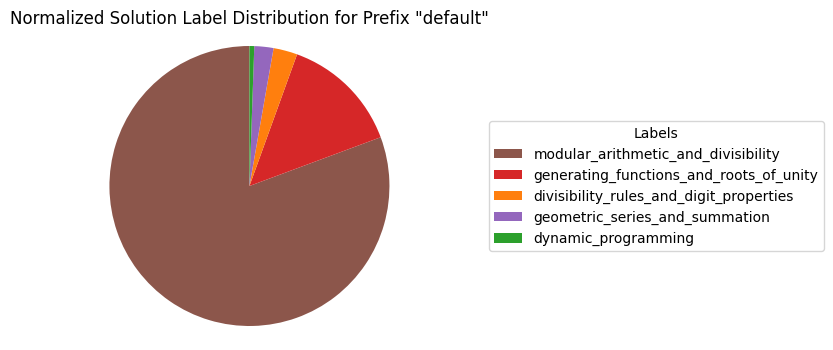

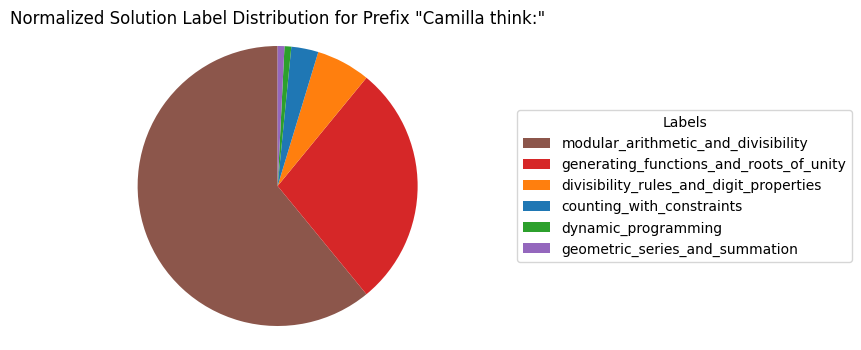

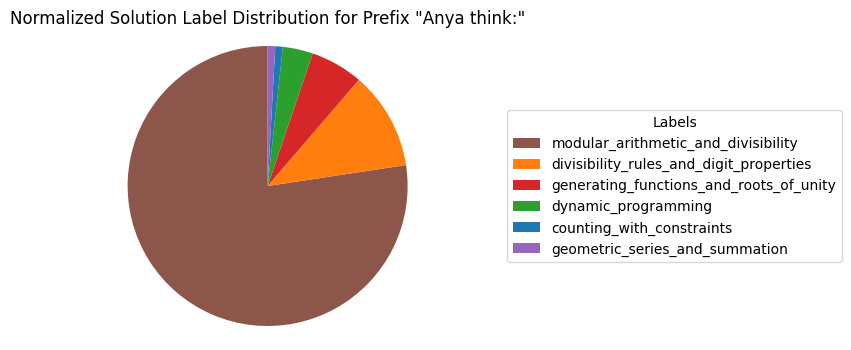

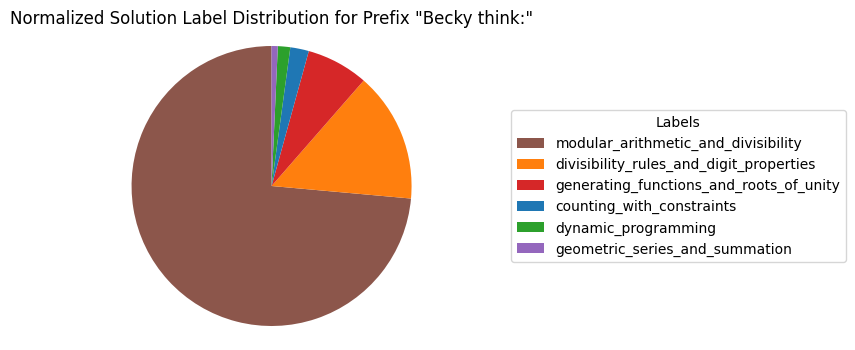

In [40]:
import matplotlib.pyplot as plt

# Assign a consistent color to each category label
all_labels = set()
for v in prefix_sols.values():
    all_labels.update([to_category[label] for label in v if label != "no_skill" and label in to_category])
all_labels = sorted(all_labels)
color_map = plt.get_cmap("tab10")  # up to 20 unique colors, adjust if more categories
label_to_color = {label: color_map(i % 10) for i, label in enumerate(all_labels)}

for k, v in prefix_sols.items():
    # Filter out "no_skill"
    v_filtered = [to_category[label] for label in v if label != "no_skill" and label in to_category]
    if not v_filtered:
        continue
    counts = Counter(v_filtered)
    total_count = sum(counts.values())
    if total_count < 20:
        continue
    # Sort counts by value DESC, then by label ASC
    sorted_items = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
    sorted_labels = [item for item, _ in sorted_items]
    sorted_counts = [count for _, count in sorted_items]
    normalized_counts = [count / total_count for count in sorted_counts]
    
    colors = [label_to_color[label] for label in sorted_labels]
    plt.figure(figsize=(6, 4))
    wedges, texts = plt.pie(
        normalized_counts,
        labels=None,  # Remove labels from the pie chart
        autopct=None, # No percentage on pie slices
        startangle=90,
        colors=colors,
    )
    plt.title(f'Normalized Solution Label Distribution for Prefix "{k}"')
    plt.axis('equal')  # Ensure pie chart is a circle
    plt.legend(
        wedges,
        sorted_labels,
        title="Labels",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )
    plt.show()